In [55]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import csv
from matplotlib import pyplot

from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [3]:
url = 'https://github.com/JieYingWu/COVID-19_US_County-level_Summaries/blob/master/data/infections_timeseries.csv'
r = requests.get(url)
text = r.iter_lines()
infection = csv.reader(text, delimiter=',')

In [4]:
url = 'https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/infections_timeseries.csv'
data = pd.read_csv(url,error_bad_lines=False,engine='python') # use sep="," for coma separation. 
data.describe()

,FIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20
count,3152.000000,3152.000000,3152.000000,3152.000000,3152.000000,3152.000000,3152.000000,3152.000000,3152.000000,3152.000000,...,3152.000000,3152.00000,3152.000000,3152.000000,3152.000000,3152.000000,3152.000000,3152.000000,3152.000000,3152.000000
mean,30287.254442,0.000317,0.000317,0.000635,0.000635,0.001586,0.001586,0.001586,0.001586,0.001586,...,228.699556,237.17132,245.212881,252.936548,262.498731,273.350571,284.973985,295.234772,303.869607,310.961294
std,15234.582582,0.017812,0.017812,0.025186,0.025186,0.039803,0.039803,0.039803,0.039803,0.039803,...,2613.467166,2677.40499,2733.343069,2792.489637,2858.161905,2937.532912,3035.122169,3129.510877,3198.222114,3247.772967
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18162.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.00000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,29166.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,11.00000,11.500000,12.000000,12.000000,13.000000,14.000000,14.000000,15.000000,15.000000
75%,45075.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,48.000000,50.00000,52.000000,55.000000,58.000000,61.000000,64.250000,68.000000,70.000000,72.000000
max,56045.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,131334.000000,134267.00000,136591.000000,139348.000000,142227.000000,145855.000000,150473.000000,155113.000000,158258.000000,160489.000000


In [5]:
data.head()

,FIPS,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20
0,1001,Autauga - Alabama - US,0,0,0,0,0,0,0,0,...,25,26,28,30,32,33,36,36,37,39
1,1003,Baldwin - Alabama - US,0,0,0,0,0,0,0,0,...,109,112,117,123,132,143,147,147,161,168
2,1005,Barbour - Alabama - US,0,0,0,0,0,0,0,0,...,18,20,22,28,29,30,32,32,33,35
3,1007,Bibb - Alabama - US,0,0,0,0,0,0,0,0,...,26,28,32,32,34,33,34,34,38,42
4,1009,Blount - Alabama - US,0,0,0,0,0,0,0,0,...,20,21,22,26,29,31,31,31,34,34


In [6]:
county_name = data.iloc[:,1]

In [65]:
'''check'''
county_name[1]

'Baldwin - Alabama - US'

In [8]:
'''Trucate data since there are too many zeros which do not help with model's training'''
data2 = data.iloc[:,64:]

In [9]:
data2.shape

(3152, 35)

In [10]:
data2.head()

,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,...,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20
0,1,4,6,6,6,6,6,7,8,10,...,25,26,28,30,32,33,36,36,37,39
1,4,4,5,5,10,15,18,19,20,24,...,109,112,117,123,132,143,147,147,161,168
2,0,0,0,0,0,0,0,0,0,0,...,18,20,22,28,29,30,32,32,33,35
3,0,0,0,0,0,0,2,3,3,4,...,26,28,32,32,34,33,34,34,38,42
4,0,1,2,4,5,5,5,5,5,6,...,20,21,22,26,29,31,31,31,34,34


In [11]:
data2T = data2.transpose()

In [12]:
data2T.head()

,0,1,2,3,4,5,6,7,8,9,...,3142,3143,3144,3145,3146,3147,3148,3149,3150,3151
3/24/20,1,4,0,0,0,0,0,2,5,0,...,2,21,0,0,0,0,0,0,0,0
3/25/20,4,4,0,0,1,0,1,2,10,1,...,3,43,0,0,0,0,0,0,0,0
3/26/20,6,5,0,0,2,2,1,2,13,1,...,3,64,0,0,0,0,0,0,0,0
3/27/20,6,5,0,0,4,2,1,3,13,1,...,4,78,0,0,0,0,0,0,0,0
3/28/20,6,10,0,0,5,3,1,3,17,1,...,8,94,0,0,0,0,0,0,0,0


In [13]:
data_T = np.asarray(data2T)
'''log transformation to make the data into linearly increase scale'''
data_log = np.log(data_T + 0.001)

In [14]:
data_T

array([[  1,   4,   0, ...,   0,   0,   0],
       [  4,   4,   0, ...,   0,   0,   0],
       [  6,   5,   0, ...,   0,   0,   0],
       ...,
       [ 36, 147,  32, ...,  83,   9, 143],
       [ 37, 161,  33, ...,  87,  10, 145],
       [ 39, 168,  35, ...,  89,  11, 148]], dtype=int64)

In [15]:
np.exp(data_log)

array([[1.00100e+00, 4.00100e+00, 1.00000e-03, ..., 1.00000e-03,
        1.00000e-03, 1.00000e-03],
       [4.00100e+00, 4.00100e+00, 1.00000e-03, ..., 1.00000e-03,
        1.00000e-03, 1.00000e-03],
       [6.00100e+00, 5.00100e+00, 1.00000e-03, ..., 1.00000e-03,
        1.00000e-03, 1.00000e-03],
       ...,
       [3.60010e+01, 1.47001e+02, 3.20010e+01, ..., 8.30010e+01,
        9.00100e+00, 1.43001e+02],
       [3.70010e+01, 1.61001e+02, 3.30010e+01, ..., 8.70010e+01,
        1.00010e+01, 1.45001e+02],
       [3.90010e+01, 1.68001e+02, 3.50010e+01, ..., 8.90010e+01,
        1.10010e+01, 1.48001e+02]])

In [19]:
'''create input data and label'''
def df_prep(df, input_step, label_step):
    X, y = list(), list()
    for i in range(len(df)):
        edge1 = i + input_step
        edge2 = edge1 + label_step

        if edge2 > len(df):
            break

        x_temp, y_temp = df[i:edge1, :], df[edge1:edge2, :]
        X.append(x_temp)
        y.append(y_temp)
    return array(X), array(y)

In [20]:
input_step, label_step = 5, 2
X, y = df_prep(data_log, input_step, label_step)

In [22]:
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(20, activation='relu', input_shape=(input_step, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(20, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features, activation='linear')))
model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
# fit model
model.fit(X, y, epochs=120,batch_size=1, validation_split=0.2, verbose=1)

Train on 23 samples, validate on 6 samples
Epoch 1/120
23/23 [==============================] - 3s 129ms/step - loss: 14.8599 - mean_squared_error: 14.8599 - val_loss: 9.0483 - val_mean_squared_error: 9.0483
Epoch 2/120
23/23 [==============================] - 0s 18ms/step - loss: 11.2466 - mean_squared_error: 11.2466 - val_loss: 17.6957 - val_mean_squared_error: 17.6957
Epoch 3/120
23/23 [==============================] - 0s 16ms/step - loss: 17.7674 - mean_squared_error: 17.7674 - val_loss: 17.5394 - val_mean_squared_error: 17.5394
Epoch 4/120
23/23 [==============================] - 0s 18ms/step - loss: 15.1194 - mean_squared_error: 15.1194 - val_loss: 11.0072 - val_mean_squared_error: 11.0072
Epoch 5/120
23/23 [==============================] - 0s 17ms/step - loss: 7.7935 - mean_squared_error: 7.7935 - val_loss: 5.6208 - val_mean_squared_error: 5.6208
Epoch 6/120
23/23 [==============================] - 0s 16ms/step - loss: 4.5194 - mean_squared_error: 4.5194 - val_loss: 4.6586 - v

Epoch 51/120
23/23 [==============================] - 0s 14ms/step - loss: 0.8252 - mean_squared_error: 0.8252 - val_loss: 1.7280 - val_mean_squared_error: 1.7280
Epoch 52/120
23/23 [==============================] - 0s 14ms/step - loss: 0.8308 - mean_squared_error: 0.8308 - val_loss: 1.5893 - val_mean_squared_error: 1.5893
Epoch 53/120
23/23 [==============================] - 0s 16ms/step - loss: 0.9196 - mean_squared_error: 0.9196 - val_loss: 1.7134 - val_mean_squared_error: 1.7134
Epoch 54/120
23/23 [==============================] - 0s 16ms/step - loss: 0.8365 - mean_squared_error: 0.8365 - val_loss: 1.7144 - val_mean_squared_error: 1.7144
Epoch 55/120
23/23 [==============================] - 0s 14ms/step - loss: 0.7956 - mean_squared_error: 0.7956 - val_loss: 1.7063 - val_mean_squared_error: 1.7063
Epoch 56/120
23/23 [==============================] - 0s 19ms/step - loss: 0.8080 - mean_squared_error: 0.8080 - val_loss: 1.6225 - val_mean_squared_error: 1.6225
Epoch 57/120
23/23 [==

23/23 [==============================] - 0s 16ms/step - loss: 0.6156 - mean_squared_error: 0.6156 - val_loss: 1.2620 - val_mean_squared_error: 1.2620
Epoch 102/120
23/23 [==============================] - 0s 16ms/step - loss: 0.5962 - mean_squared_error: 0.5962 - val_loss: 1.1579 - val_mean_squared_error: 1.1579
Epoch 103/120
23/23 [==============================] - 0s 14ms/step - loss: 0.5848 - mean_squared_error: 0.5848 - val_loss: 1.2304 - val_mean_squared_error: 1.2304
Epoch 104/120
23/23 [==============================] - 0s 16ms/step - loss: 0.5704 - mean_squared_error: 0.5704 - val_loss: 1.1461 - val_mean_squared_error: 1.1461
Epoch 105/120
23/23 [==============================] - 0s 14ms/step - loss: 0.5750 - mean_squared_error: 0.5750 - val_loss: 1.1728 - val_mean_squared_error: 1.1728
Epoch 106/120
23/23 [==============================] - 0s 16ms/step - loss: 0.5648 - mean_squared_error: 0.5648 - val_loss: 1.1557 - val_mean_squared_error: 1.1557
Epoch 107/120
23/23 [=========

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                253840    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 2, 20)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 2, 20)             3280      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 2, 3152)           66192     
Total params: 323,312
Trainable params: 323,312
Non-trainable params: 0
_________________________________________________________________


In [66]:
# demonstrate prediction
x_input = X[25]
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[[ 3.302758   4.789466   3.3771918 ... -1.9598694 -2.710073  -1.7150147]
  [ 3.4068565  4.9478083  2.6653302 ... -1.8586892 -2.6653624 -1.5908709]]]


In [67]:
x_input

array([[[ 3.21891582,  4.69135706,  2.89042731, ..., -6.90775528,
         -6.90775528, -6.90775528],
        [ 3.258135  ,  4.7185078 ,  2.99578227, ...,  4.18966989,
          2.30268509,  4.7791319 ],
        [ 3.33224022,  4.76218248,  3.09108791, ...,  4.24850953,
          2.30268509,  4.82028963],
        [ 3.40123071,  4.81219249,  3.33224022, ...,  4.24850953,
          2.30268509,  4.83628984],
        [ 3.46576715,  4.8828095 ,  3.36733031, ...,  4.24850953,
          2.19733568,  4.86754214]]])

In [29]:
y_exp = np.exp(yhat)
y_exp = np.squeeze(y_exp)
y_exp.shape
y_2day_pred = y_exp.transpose()

In [68]:
'''Use the final 5 days to predict the next 2 days'''
data_5days  = np.asarray(data2.iloc[:,-5:])
data_5days_t = np.transpose(np.log(data_5days + 0.001))

In [101]:
'''Use any 5 days to validate result'''
data_5days2  = np.asarray(data2.iloc[:,10:15])
data_5days2_t = np.transpose(np.log(data_5days2 + 0.001))

In [70]:
data_5days_t = data_5days_t.reshape((1, n_steps_in, n_features))
yhat = model.predict(data_5days_t, verbose=0)
y_2d = np.exp(yhat)

In [102]:
data_5days2_t = data_5days2_t.reshape((1, n_steps_in, n_features))
yhat2 = model.predict(data_5days2_t, verbose=0)
y_2d2 = np.exp(yhat2)

In [71]:
y_2d

array([[[2.6848015e+01, 1.1804070e+02, 2.8892275e+01, ...,
         1.4193329e-01, 6.7223363e-02, 1.8111244e-01],
        [2.9781227e+01, 1.3820599e+02, 1.4218191e+01, ...,
         1.5698309e-01, 7.0284799e-02, 2.0495115e-01]]], dtype=float32)

In [103]:
y_2d2

array([[[1.5697268e+01, 5.7931862e+01, 3.3190632e+00, ...,
         6.2775827e-04, 6.2733126e-04, 6.2498089e-04],
        [1.6510458e+01, 6.0492596e+01, 6.3134589e+00, ...,
         7.3080632e-04, 7.1872218e-04, 7.0787000e-04]]], dtype=float32)

In [104]:
pred1 = y_2d[0][0][1]
pred2 = y_2d[0][1][1]

pred1_2 = y_2d2[0][0][1]
pred2_2 = y_2d2[0][1][1]

In [72]:
example = np.asarray(data.iloc[1,64:])

In [85]:
len(example)

35

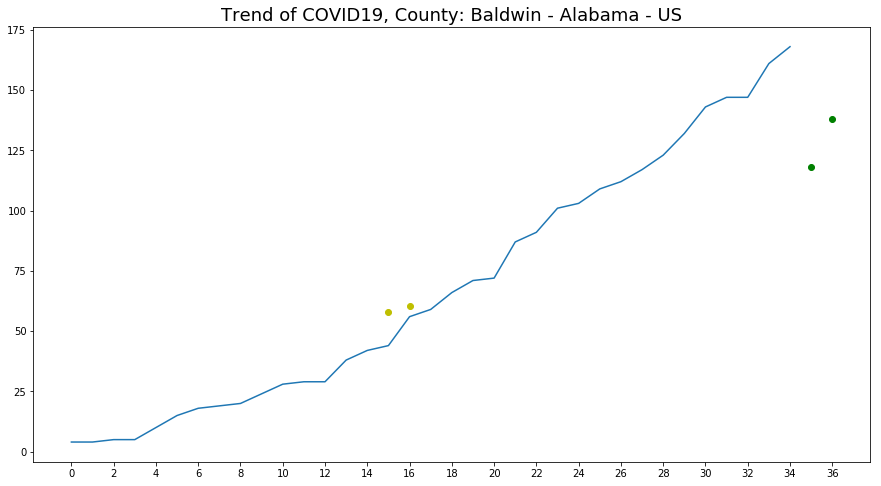

In [105]:
pyplot.figure(figsize=(15,8))
pyplot.title('Trend of COVID19, County: '+str(county_name[1]), fontsize=18)
pyplot.plot(example)
pyplot.xticks(np.arange(0, 40, 2))
pyplot.yticks(np.arange(0, 200, 25))
pyplot.plot(35,pred1,'go')
pyplot.plot(36,pred2,'go')

pyplot.plot(15,pred1_2,'yo')
pyplot.plot(16,pred2_2,'yo')